In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import numpy as np
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

# add reproducibility stuff
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


GPU is not available


In [ ]:
def fastfood_vars(DD, device=0):
    """
    Returns parameters for fast food transform
    :param DD: desired dimension
    :return:
    """
    ll = int(np.ceil(np.log(DD) / np.log(2)))
    LL = 2**ll

    # Binary scaling matrix where $B_{i,i} \in \{\pm 1 \}$ drawn iid
    BB = torch.FloatTensor(LL).uniform_(0, 2).type(torch.LongTensor)
    BB = (BB * 2 - 1).type(torch.FloatTensor).to(device)
    BB.requires_grad = False

    # Random permutation matrix
    Pi = torch.LongTensor(np.random.permutation(LL)).to(device)
    Pi.requires_grad = False

    # Gaussian scaling matrix, whose elements $G_{i,i} \sim \mathcal{N}(0, 1)$
    GG = (
        torch.FloatTensor(
            LL,
        )
        .normal_()
        .to(device)
    )
    GG.requires_grad = False

    divisor = torch.sqrt(LL * torch.sum(torch.pow(GG, 2)))

    return [BB, Pi, GG, divisor, LL]


In [ ]:
def fast_walsh_hadamard_torched(x, axis=0, normalize=False):
    """
    Performs fast Walsh Hadamard transform
    :param x:
    :param axis:
    :param normalize:
    :return:
    """
    orig_shape = x.size()
    assert axis >= 0 and axis < len(
        orig_shape
    ), "For a vector of shape %s, axis must be in [0, %d] but it is %d" % (
        orig_shape,
        len(orig_shape) - 1,
        axis,
    )
    h_dim = orig_shape[axis]
    h_dim_exp = int(round(np.log(h_dim) / np.log(2)))
    assert h_dim == 2**h_dim_exp, (
        "hadamard can only be computed over axis with size that is a power of two, but"
        " chosen axis %d has size %d" % (axis, h_dim)
    )

    working_shape_pre = [int(np.prod(orig_shape[:axis]))]  # prod of empty array is 1 :)
    working_shape_post = [
        int(np.prod(orig_shape[axis + 1 :]))
    ]  # prod of empty array is 1 :)
    working_shape_mid = [2] * h_dim_exp
    working_shape = working_shape_pre + working_shape_mid + working_shape_post

    ret = x.view(working_shape)

    for ii in range(h_dim_exp):
        dim = ii + 1
        arrs = torch.chunk(ret, 2, dim=dim)
        assert len(arrs) == 2
        ret = torch.cat((arrs[0] + arrs[1], arrs[0] - arrs[1]), axis=dim)

    if normalize:
        ret = ret / torch.sqrt(float(h_dim))

    ret = ret.view(orig_shape)

    return ret


In [ ]:
def fastfood_torched(x, DD, param_list=None, device=0):
    """
    Fastfood transform
    :param x: array of dd dimension
    :param DD: desired dimension
    :return:
    """
    dd = x.size(0)

    if not param_list:

        BB, Pi, GG, divisor, LL = fastfood_vars(DD, device=device)

    else:

        BB, Pi, GG, divisor, LL = param_list

    # Padd x if needed
    dd_pad = F.pad(x, pad=(0, LL - dd), value=0, mode="constant")

    # From left to right HGPiH(BX), where H is Walsh-Hadamard matrix
    mul_1 = torch.mul(BB, dd_pad)
    # HGPi(HBX)
    mul_2 = fast_walsh_hadamard_torched(mul_1, 0, normalize=False)

    # HG(PiHBX)
    mul_3 = mul_2[Pi]

    # H(GPiHBX)
    mul_4 = torch.mul(mul_3, GG)

    # (HGPiHBX)
    mul_5 = fast_walsh_hadamard_torched(mul_4, 0, normalize=False)

    ret = torch.div(mul_5[:DD], divisor * np.sqrt(float(DD) / LL))

    return ret


In [2]:
class FastfoodWrapper(nn.Module):
    def __init__(self, module, intrinsic_dimension, device):
        """
        Wrapper to estimate the intrinsic dimensionality of the
        objective landscape for a specific task given a specific model using FastFood transform
        :param module: pytorch nn.Module
        :param intrinsic_dimension: dimensionality within which we search for solution
        :param device: cuda device id
        """
        super(FastfoodWrapper, self).__init__()

        # Hide this from inspection by get_parameters()
        self.m = [module]

        self.name_base_localname = []

        # Stores the initial value: \theta_{0}^{D}
        self.initial_value = dict()

        # Fastfood parameters
        self.fastfood_params = {}

        # Parameter vector that is updated
        # Initialised with zeros as per text: \theta^{d}
        V = nn.Parameter(torch.zeros((intrinsic_dimension)).to(device))
        self.register_parameter("V", V)
        v_size = (intrinsic_dimension,)

        # Iterate over layers in the module
        for name, param in module.named_parameters():
            # If param requires grad update
            if param.requires_grad:

                # Saves the initial values of the initialised parameters from param.data and sets them to no grad.
                # (initial values are the 'origin' of the search)
                self.initial_value[name] = v0 = (
                    param.clone().detach().requires_grad_(False).to(device)
                )

                # Generate fastfood parameters
                DD = np.prod(v0.size())
                self.fastfood_params[name] = fastfood_vars(DD, device)

                base, localname = module, name
                while "." in localname:
                    prefix, localname = localname.split(".", 1)
                    base = base.__getattr__(prefix)
                self.name_base_localname.append((name, base, localname))

        for name, base, localname in self.name_base_localname:
            delattr(base, localname)

    def forward(self, x):
        # Iterate over layers
        for name, base, localname in self.name_base_localname:

            init_shape = self.initial_value[name].size()
            DD = np.prod(init_shape)

            # Fastfood transform te replace dence P
            ray = fastfood_torched(self.V, DD, self.fastfood_params[name]).view(
                init_shape
            )

            param = self.initial_value[name] + ray

            setattr(base, localname, param)

        # Pass through the model, by getting hte module from a list self.m
        module = self.m[0]
        x = module(x)
        return x


In [6]:
class DenseWrap(nn.Module):
    def __init__(self, module, intrinsic_dimension, device):
        """
        Wrapper to estimate the intrinsic dimensionality of the
        objective landscape for a specific task given a specific model
        :param module: pytorch nn.Module
        :param intrinsic_dimension: dimensionality within which we search for solution
        :param device: cuda device id
        """
        super(DenseWrap, self).__init__()

        # Hide this from inspection by get_parameters()
        self.m = [module]

        self.name_base_localname = []

        # Stores the initial value: \theta_{0}^{D}
        self.initial_value = dict()

        # Stores the randomly generated projection matrix P
        self.random_matrix = dict()

        # Parameter vector that is updated, initialised with zeros as per text: \theta^{d}
        V = nn.Parameter(torch.zeros((intrinsic_dimension, 1)).to(device))
        self.register_parameter("V", V)
        v_size = (intrinsic_dimension,)

        # Iterates over layers in the Neural Network
        for name, param in module.named_parameters():
            # If the parameter requires gradient update
            if param.requires_grad:

                # Saves the initial values of the initialised parameters from param.data and sets them to no grad.
                # (initial values are the 'origin' of the search)
                self.initial_value[name] = v0 = (
                    param.clone().detach().requires_grad_(False).to(device)
                )

                # If v0.size() is [4, 3], then below operation makes it [4, 3, v_size]
                matrix_size = v0.size() + v_size

                # Generates random projection matrices P, sets them to no grad
                self.random_matrix[name] = (
                    torch.randn(matrix_size, requires_grad=False).to(device)
                    / intrinsic_dimension**0.5
                )

                # NOTE!: lines below are not clear!
                base, localname = module, name
                while "." in localname:
                    prefix, localname = localname.split(".", 1)
                    base = base.__getattr__(prefix)
                self.name_base_localname.append((name, base, localname))

        for name, base, localname in self.name_base_localname:
            delattr(base, localname)

    def forward(self, x):
        # Iterate over the layers
        for name, base, localname in self.name_base_localname:

            # Product between matrix P and \theta^{d}
            ray = torch.matmul(self.random_matrix[name], self.V)

            # Add the \theta_{0}^{D} to P \dot \theta^{d}
            param = self.initial_value[name] + torch.squeeze(ray, -1)

            setattr(base, localname, param)

        # Pass through the model, by getting the module from a list self.m
        module = self.m[0]
        x = module(x)
        return x


In [8]:
# implementig the code from the paper https://arxiv.org/abs/1804.08838 in pytorch
class Classifier(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, n_classes)
        self.maxpool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x):
        x = self.maxpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x


def get_resnet(encoder_name, num_classes, pretrained=False):
    assert encoder_name in [
        "resnet18",
        "resnet50",
    ], "{} is a wrong encoder name!".format(encoder_name)
    if encoder_name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        latent_dim = 512
    else:
        model = models.resnet50(pretrained=pretrained)
        latent_dim = 2048
    children = list(model.children())[:-2] + [Classifier(latent_dim, num_classes)]
    model = torch.nn.Sequential(*children)
    return model


# Get model and wrap it in fastfood
model = get_resnet("resnet18", num_classes=YOUR_NUMBER_OF_CLASSES).cuda()
model = FastfoodWrapper(model, intrinsic_dimension=100, device=device)


NameError: name 'YOUR_NUMBER_OF_CLASSES' is not defined

In [22]:
# Class for a Fully Connected Network
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
# Class for Standard LeNet Network, reference http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf with some modification to follow the same number of parameters as the main paper for the task does
class LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LeNet, self).__init__()
        # 6 kernels 5x5
        self.conv1 = nn.Conv2d(input_dim, 6, 5, padding='valid',)
        # max-pooling over 2x2
        self.pool1 = nn.MaxPool2d(2, stride=2)
        # 16 kernels 5x5
        self.conv2 = nn.Conv2d(6, 16, 5, padding='valid')
        # max-pooling over 2x2
        self.pool2 = nn.MaxPool2d(2, stride=2)
        # 120 kernels 4x4 to match the dimensionality of the fully connected network
        self.conv3 = nn.Conv2d(16, 120, 4,)
        # 120 fully connected neurons, too many parameter in this case w.r.t. the paper
        #self.fc1 = nn.Linear(16 * 5 * 5, 120,)
        self.flat = nn.Flatten(start_dim=1)
        # 84 fully connected neurons
        self.fc2 = nn.Linear(120, 84)
        # 10 fully connected neurons
        self.fc3 = nn.Linear(84, output_dim,)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
from torch.nn.modules.utils import _pair

# from https://discuss.pytorch.org/t/locally-connected-layers/26979
class LocallyConnected2d(nn.Module):
    def __init__(self, in_channels, out_channels, output_size, kernel_size, stride=1, bias=True):
        super(LocallyConnected2d, self).__init__()
        output_size = _pair(output_size)
        self.weight = nn.Parameter(
            nn.init.kaiming_normal_(torch.randn(1, out_channels, in_channels, output_size[0], output_size[1], kernel_size**2), nonlinearity='relu')
        )
        if bias:
            self.bias = nn.Parameter(nn.init.kaiming_normal_(
                torch.randn(1, out_channels, output_size[0], output_size[1]), nonlinearity='relu')
            )
        else:
            self.register_parameter('bias', None)
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        
    def forward(self, x):
        _, c, h, w = x.size()
        kh, kw = self.kernel_size
        dh, dw = self.stride
        x = x.unfold(2, kh, dh).unfold(3, kw, dw)
        x = x.contiguous().view(*x.size()[:-2], -1)
        # Sum in in_channel and kernel_size dims
        out = (x.unsqueeze(1) * self.weight).sum([2, -1])
        if self.bias is not None:
            out += self.bias
        return out

# Class for Untied LeNet Network
class Untied_LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Untied_LeNet, self).__init__()
        # 6 kernels 5x5
        self.conv1 = LocallyConnected2d(input_dim, 6, (24,24), 5)
        # max-pooling over 2x2
        self.pool1 = nn.MaxPool2d(2, stride=2)
        # 16 kernels 5x5
        self.conv2 = LocallyConnected2d(6, 16, (8,8), 5)
        # max-pooling over 2x2
        self.pool2 = nn.MaxPool2d(2, stride=2)
        # 120 kernels 4x4 to match the dimensionality of the fully connected network
        self.conv3 = LocallyConnected2d(16, 120, (1,1), 4)
        # 120 fully connected neurons, too many parameter in this case w.r.t. the paper
        #self.fc1 = nn.Linear(16 * 5 * 5, 120,)
        self.flat = nn.Flatten(start_dim=1)
        # 84 fully connected neurons
        self.fc2 = nn.Linear(120, 84)
        # 10 fully connected neurons
        self.fc3 = nn.Linear(84, output_dim,)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
# Class for FC-LeNet Network
class FcLeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FcLeNet, self).__init__()
        # 6 kernels 5x5
        self.fcconv1 = nn.Linear(input_dim, 3456)
        # max-pooling over 2x2
        self.pool1 = nn.MaxPool2d(2, stride=2)
        # 16 kernels 5x5
        self.fcconv2 = nn.Linear(864, 1024)
        # max-pooling over 2x2
        self.pool2 = nn.MaxPool2d(2, stride=2)
        # 120 kernels 4x4 to match the dimensionality of the fully connected network
        self.fcconv3 = nn.Linear(256, 120)
        # 120 fully connected neurons, too many parameter in this case w.r.t. the paper
        #self.fc1 = nn.Linear(16 * 5 * 5, 120,)
        self.flat = nn.Flatten(start_dim=1)
        # 84 fully connected neurons
        self.fc2 = nn.Linear(120, 84)
        # 10 fully connected neurons
        self.fc3 = nn.Linear(84, output_dim,)

    def forward(self, x):
        x = self.pool1(F.relu(self.fcconv1(x)).view(-1,6,24,24))
        x = self.flat(x)
        x = self.pool2(F.relu(self.fcconv2(x)).view(-1,16,8,8))
        x = self.flat(x)
        x = F.relu(self.fcconv3(x))
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [22]:
# Class for FCTied-LeNet
class FCTied_LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCTied_LeNet, self).__init__()
        # 6 kernels 5x5
        self.conv1 = nn.Conv2d(input_dim, 6, 55, padding='same',)
        # max-pooling over 2x2
        self.pool1 = nn.MaxPool2d(2, stride=2)
        # 16 kernels 5x5
        self.conv2 = nn.Conv2d(6, 16, 27, padding='same')
        # max-pooling over 2x2
        self.pool2 = nn.MaxPool2d(2, stride=2)
        # 120 kernels 4x4 to match the dimensionality of the fully connected network
        self.conv3 = nn.Conv2d(16, 120, 7,)
        # 120 fully connected neurons, too many parameter in this case w.r.t. the paper
        #self.fc1 = nn.Linear(16 * 5 * 5, 120,)
        self.flat = nn.Flatten(start_dim=1)
        # 84 fully connected neurons
        self.fc2 = nn.Linear(120, 84)
        # 10 fully connected neurons
        self.fc3 = nn.Linear(84, output_dim,)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
batch_size = 128

img_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))]
)

# download and load MNIST Dataset
train_dataset = MNIST(
    root="./data/MNIST", download=True, train=True, transform=img_transform
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(
    root="./data/MNIST", download=True, train=False, transform=img_transform
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)


In [ ]:
# download and load CIFAR-10 Dataset
train_dataset = CIFAR10(
    root="./data/CIFAR10", download=True, train=True, transform=img_transform
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(
    root="./data/CIFAR10", download=True, train=False, transform=img_transform
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)


In [24]:
model = FullyConnectedNetwork(28 * 28, 200, 10)
model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)


Number of parameters: 199210


In [9]:
model = LeNet(1, 10)
model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)

Number of parameters: 44426


In [9]:
model = Untied_LeNet(1, 10)
model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)

Number of parameters: 286334


In [31]:
model = FcLeNet(28 * 28, 10)
model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)


Number of parameters: 3640574


In [23]:
model = FCTied_LeNet(1, 10)
model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)

Number of parameters: 193370


In [10]:
model_intrinsic = DenseWrap(model, intrinsic_dimension=300, device=device)
num_params = sum(p.numel() for p in model_intrinsic.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)


Number of parameters: 300


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305695
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.305219
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.289299
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.294029
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.291496
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.283010
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.256650
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.207574
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.091959
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.041307
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.868689
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.133733
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.233037
Train Epoch: 1 [16640/60000 (28%)]	Loss: 1.719699
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.378980
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.507824
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.850024
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.005746
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.688205
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.942108
Train Epoch: 1 [

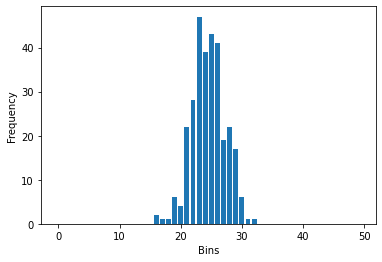

Accuracy: 0.8667
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.382424
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.781963
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.421566
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.483857
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.685827
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.350003
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.603183
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.656359
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.515621
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.428424
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.440377
Train Epoch: 2 [14080/60000 (23%)]	Loss: 3.014735
Train Epoch: 2 [15360/60000 (26%)]	Loss: 1.771904
Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.959940
Train Epoch: 2 [17920/60000 (30%)]	Loss: 0.483777
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.742873
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.562546
Train Epoch: 2 [21760/60000 (36%)]	Loss: 0.745499
Train Epoch: 2 [23040/60000 (38%)]	Loss: 0.537878
Train Epoch: 2 [24320/60000 (41%)]	Loss: 0.544722

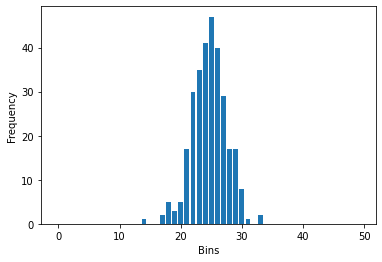

Accuracy: 0.74
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.701486
Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.512738
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.313868
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.438828
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.485063
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.436250
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.553594
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.475698
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.405117
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.630333
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.384990
Train Epoch: 3 [14080/60000 (23%)]	Loss: 0.535364
Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.402966
Train Epoch: 3 [16640/60000 (28%)]	Loss: 0.486567
Train Epoch: 3 [17920/60000 (30%)]	Loss: 0.345537
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.693022
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.639206
Train Epoch: 3 [21760/60000 (36%)]	Loss: 0.523739
Train Epoch: 3 [23040/60000 (38%)]	Loss: 0.250072
Train Epoch: 3 [24320/60000 (41%)]	Loss: 0.461339
T

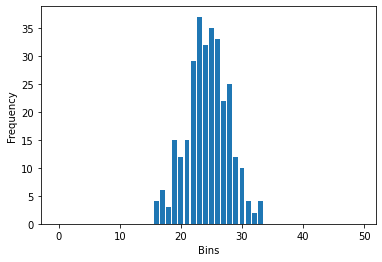

Accuracy: 0.3753
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.641518
Train Epoch: 4 [1280/60000 (2%)]	Loss: 1.064035
Train Epoch: 4 [2560/60000 (4%)]	Loss: 1.321019
Train Epoch: 4 [3840/60000 (6%)]	Loss: 1.198430
Train Epoch: 4 [5120/60000 (9%)]	Loss: 1.031120
Train Epoch: 4 [6400/60000 (11%)]	Loss: 1.114285
Train Epoch: 4 [7680/60000 (13%)]	Loss: 1.275636
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.978807
Train Epoch: 4 [10240/60000 (17%)]	Loss: 1.446609
Train Epoch: 4 [11520/60000 (19%)]	Loss: 1.005626
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.100927
Train Epoch: 4 [14080/60000 (23%)]	Loss: 0.785494
Train Epoch: 4 [15360/60000 (26%)]	Loss: 0.649747
Train Epoch: 4 [16640/60000 (28%)]	Loss: 1.254163
Train Epoch: 4 [17920/60000 (30%)]	Loss: 0.965290
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.046800
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.705192
Train Epoch: 4 [21760/60000 (36%)]	Loss: 1.075197
Train Epoch: 4 [23040/60000 (38%)]	Loss: 1.414209
Train Epoch: 4 [24320/60000 (41%)]	Loss: 1.346130

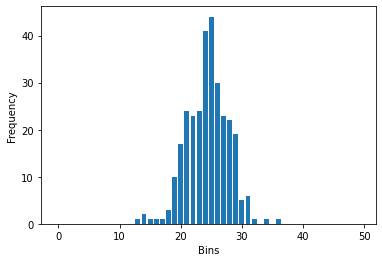

Accuracy: 0.8248
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.599259
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.755713
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.972729
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.752258
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.432772
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.966018
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.678503
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.629919
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.443124
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.660302
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.728742
Train Epoch: 5 [14080/60000 (23%)]	Loss: 1.001091
Train Epoch: 5 [15360/60000 (26%)]	Loss: 0.503653
Train Epoch: 5 [16640/60000 (28%)]	Loss: 0.674169
Train Epoch: 5 [17920/60000 (30%)]	Loss: 0.597496
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.816956
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.347598
Train Epoch: 5 [21760/60000 (36%)]	Loss: 1.065673
Train Epoch: 5 [23040/60000 (38%)]	Loss: 2.322532
Train Epoch: 5 [24320/60000 (41%)]	Loss: 2.282658

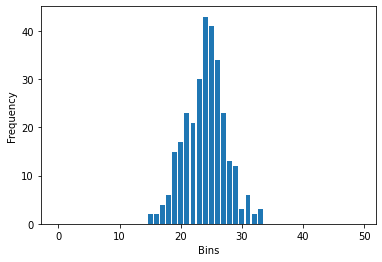

Accuracy: 0.6131
Train Epoch: 6 [0/60000 (0%)]	Loss: 1.294270
Train Epoch: 6 [1280/60000 (2%)]	Loss: 1.112762
Train Epoch: 6 [2560/60000 (4%)]	Loss: 1.038607
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.712215
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.821686
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.773979
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.997493
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.800713
Train Epoch: 6 [10240/60000 (17%)]	Loss: 1.219702
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.798620
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.697209
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.860874
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.597257
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.646277
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.772827
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.460885
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.763206
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.611654
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.500807
Train Epoch: 6 [24320/60000 (41%)]	Loss: 1.055191

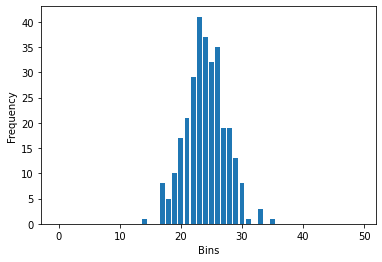

Accuracy: 0.8523
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.301194
Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.447538
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.392163
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.702581
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.665674
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.510491
Train Epoch: 7 [7680/60000 (13%)]	Loss: 1.487755
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.634692
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.508089
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.583177
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.353119
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.396367
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.471886
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.250544
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.581572
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.520460
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.412907
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.362896
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.699499
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.660265

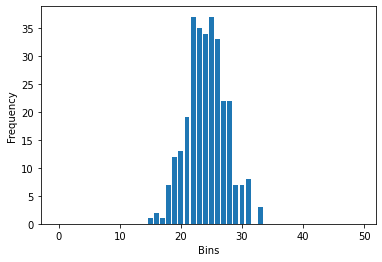

Accuracy: 0.7674
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.633954
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.381994
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.687866
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.493853
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.430507
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.526735
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.636773
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.611585
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.456055
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.327128
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.489991
Train Epoch: 8 [14080/60000 (23%)]	Loss: 0.617579
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.719144
Train Epoch: 8 [16640/60000 (28%)]	Loss: 0.294396
Train Epoch: 8 [17920/60000 (30%)]	Loss: 0.459761
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.425398
Train Epoch: 8 [20480/60000 (34%)]	Loss: 0.806041
Train Epoch: 8 [21760/60000 (36%)]	Loss: 0.484555
Train Epoch: 8 [23040/60000 (38%)]	Loss: 0.560622
Train Epoch: 8 [24320/60000 (41%)]	Loss: 0.374980

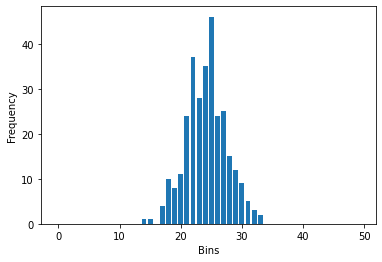

Accuracy: 0.8667
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.649249
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.495876
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.605429
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.335220
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.419413
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.574863
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.325904
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.448205
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.500020
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.752972
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.396227
Train Epoch: 9 [14080/60000 (23%)]	Loss: 0.225444
Train Epoch: 9 [15360/60000 (26%)]	Loss: 0.330139
Train Epoch: 9 [16640/60000 (28%)]	Loss: 0.547667
Train Epoch: 9 [17920/60000 (30%)]	Loss: 0.291623
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.536425
Train Epoch: 9 [20480/60000 (34%)]	Loss: 0.501798
Train Epoch: 9 [21760/60000 (36%)]	Loss: 0.591198
Train Epoch: 9 [23040/60000 (38%)]	Loss: 0.661896
Train Epoch: 9 [24320/60000 (41%)]	Loss: 0.411290

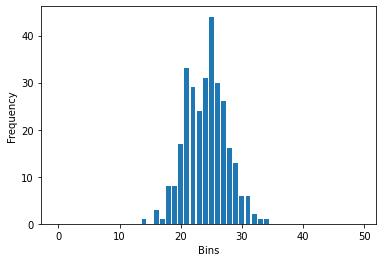

Accuracy: 0.8882
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.390640
Train Epoch: 10 [1280/60000 (2%)]	Loss: 0.254966
Train Epoch: 10 [2560/60000 (4%)]	Loss: 0.350228
Train Epoch: 10 [3840/60000 (6%)]	Loss: 0.400383
Train Epoch: 10 [5120/60000 (9%)]	Loss: 0.481048
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.511570
Train Epoch: 10 [7680/60000 (13%)]	Loss: 0.474295
Train Epoch: 10 [8960/60000 (15%)]	Loss: 0.467408
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.465828
Train Epoch: 10 [11520/60000 (19%)]	Loss: 0.443055
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.382325
Train Epoch: 10 [14080/60000 (23%)]	Loss: 0.351756
Train Epoch: 10 [15360/60000 (26%)]	Loss: 0.513272
Train Epoch: 10 [16640/60000 (28%)]	Loss: 0.466146
Train Epoch: 10 [17920/60000 (30%)]	Loss: 0.521398
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.430504
Train Epoch: 10 [20480/60000 (34%)]	Loss: 0.417179
Train Epoch: 10 [21760/60000 (36%)]	Loss: 0.361578
Train Epoch: 10 [23040/60000 (38%)]	Loss: 0.405665
Train Epoch: 10 [24320/60000 (

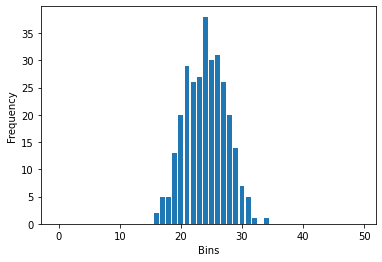

Accuracy: 0.8748
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.299435
Train Epoch: 11 [1280/60000 (2%)]	Loss: 0.199536
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.548614
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.442585
Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.393089
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.385577
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.662432
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.578155
Train Epoch: 11 [10240/60000 (17%)]	Loss: 1.132005
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.464580
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.471298
Train Epoch: 11 [14080/60000 (23%)]	Loss: 0.321471
Train Epoch: 11 [15360/60000 (26%)]	Loss: 0.262998
Train Epoch: 11 [16640/60000 (28%)]	Loss: 0.492812
Train Epoch: 11 [17920/60000 (30%)]	Loss: 0.280064
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.481755
Train Epoch: 11 [20480/60000 (34%)]	Loss: 0.376709
Train Epoch: 11 [21760/60000 (36%)]	Loss: 0.270534
Train Epoch: 11 [23040/60000 (38%)]	Loss: 0.467768
Train Epoch: 11 [24320/60000 (

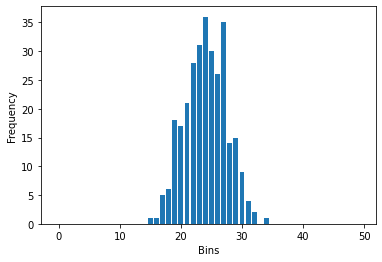

Accuracy: 0.8391
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.499792
Train Epoch: 12 [1280/60000 (2%)]	Loss: 0.352483
Train Epoch: 12 [2560/60000 (4%)]	Loss: 0.293417
Train Epoch: 12 [3840/60000 (6%)]	Loss: 0.389510
Train Epoch: 12 [5120/60000 (9%)]	Loss: 0.448183
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.484976
Train Epoch: 12 [7680/60000 (13%)]	Loss: 0.297610
Train Epoch: 12 [8960/60000 (15%)]	Loss: 0.404087
Train Epoch: 12 [10240/60000 (17%)]	Loss: 0.510223
Train Epoch: 12 [11520/60000 (19%)]	Loss: 0.753495
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.423534
Train Epoch: 12 [14080/60000 (23%)]	Loss: 0.438117
Train Epoch: 12 [15360/60000 (26%)]	Loss: 0.642299
Train Epoch: 12 [16640/60000 (28%)]	Loss: 0.416243
Train Epoch: 12 [17920/60000 (30%)]	Loss: 0.503644
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.485262
Train Epoch: 12 [20480/60000 (34%)]	Loss: 0.477617
Train Epoch: 12 [21760/60000 (36%)]	Loss: 0.506624
Train Epoch: 12 [23040/60000 (38%)]	Loss: 0.459118
Train Epoch: 12 [24320/60000 (

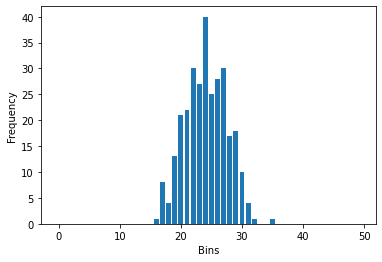

Accuracy: 0.8536
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.442723
Train Epoch: 13 [1280/60000 (2%)]	Loss: 0.645496
Train Epoch: 13 [2560/60000 (4%)]	Loss: 0.451310
Train Epoch: 13 [3840/60000 (6%)]	Loss: 0.377914
Train Epoch: 13 [5120/60000 (9%)]	Loss: 0.451068
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.322531
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.378850
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.347454
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.686349
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.386087
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.360725
Train Epoch: 13 [14080/60000 (23%)]	Loss: 0.443200
Train Epoch: 13 [15360/60000 (26%)]	Loss: 0.380217
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.320274
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.372771
Train Epoch: 13 [19200/60000 (32%)]	Loss: 1.494520
Train Epoch: 13 [20480/60000 (34%)]	Loss: 0.415875
Train Epoch: 13 [21760/60000 (36%)]	Loss: 0.453872
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.362078
Train Epoch: 13 [24320/60000 (

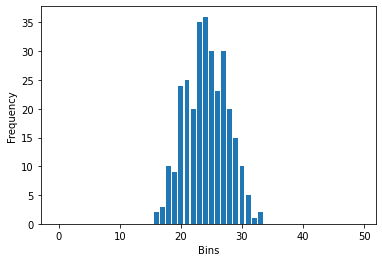

Accuracy: 0.8485
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.420267
Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.459754
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.468896
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.870543
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.496444
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.449576
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.567721
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.430917
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.374555
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.458189
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.568477
Train Epoch: 14 [14080/60000 (23%)]	Loss: 0.488823
Train Epoch: 14 [15360/60000 (26%)]	Loss: 0.343949
Train Epoch: 14 [16640/60000 (28%)]	Loss: 0.439605
Train Epoch: 14 [17920/60000 (30%)]	Loss: 0.467239
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.436539
Train Epoch: 14 [20480/60000 (34%)]	Loss: 0.550113
Train Epoch: 14 [21760/60000 (36%)]	Loss: 0.383387
Train Epoch: 14 [23040/60000 (38%)]	Loss: 0.449900
Train Epoch: 14 [24320/60000 (

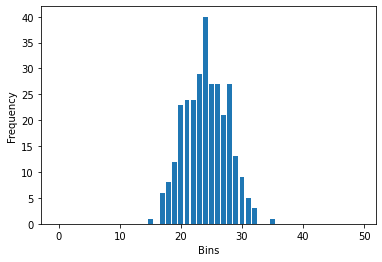

Accuracy: 0.8878
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.278611
Train Epoch: 15 [1280/60000 (2%)]	Loss: 0.446193
Train Epoch: 15 [2560/60000 (4%)]	Loss: 0.373947
Train Epoch: 15 [3840/60000 (6%)]	Loss: 0.418988
Train Epoch: 15 [5120/60000 (9%)]	Loss: 0.603709
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.420587
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.433804
Train Epoch: 15 [8960/60000 (15%)]	Loss: 0.227972
Train Epoch: 15 [10240/60000 (17%)]	Loss: 0.465845
Train Epoch: 15 [11520/60000 (19%)]	Loss: 0.383122
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.490210
Train Epoch: 15 [14080/60000 (23%)]	Loss: 0.363415
Train Epoch: 15 [15360/60000 (26%)]	Loss: 0.554180
Train Epoch: 15 [16640/60000 (28%)]	Loss: 0.762823
Train Epoch: 15 [17920/60000 (30%)]	Loss: 0.321118
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.299156
Train Epoch: 15 [20480/60000 (34%)]	Loss: 0.392792
Train Epoch: 15 [21760/60000 (36%)]	Loss: 0.584212
Train Epoch: 15 [23040/60000 (38%)]	Loss: 0.445837
Train Epoch: 15 [24320/60000 (

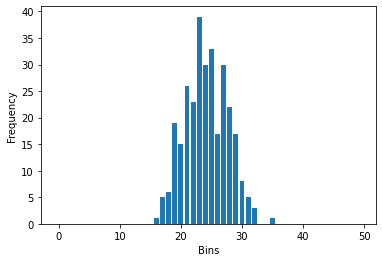

Accuracy: 0.7949
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.558310
Train Epoch: 16 [1280/60000 (2%)]	Loss: 0.421369
Train Epoch: 16 [2560/60000 (4%)]	Loss: 0.342731
Train Epoch: 16 [3840/60000 (6%)]	Loss: 0.424437
Train Epoch: 16 [5120/60000 (9%)]	Loss: 0.317259
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.352389
Train Epoch: 16 [7680/60000 (13%)]	Loss: 0.346699
Train Epoch: 16 [8960/60000 (15%)]	Loss: 0.343506
Train Epoch: 16 [10240/60000 (17%)]	Loss: 0.665815
Train Epoch: 16 [11520/60000 (19%)]	Loss: 0.331527
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.529111
Train Epoch: 16 [14080/60000 (23%)]	Loss: 0.437367
Train Epoch: 16 [15360/60000 (26%)]	Loss: 0.307090
Train Epoch: 16 [16640/60000 (28%)]	Loss: 0.823096
Train Epoch: 16 [17920/60000 (30%)]	Loss: 0.196798
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.354883
Train Epoch: 16 [20480/60000 (34%)]	Loss: 0.401370
Train Epoch: 16 [21760/60000 (36%)]	Loss: 0.378985
Train Epoch: 16 [23040/60000 (38%)]	Loss: 0.451560
Train Epoch: 16 [24320/60000 (

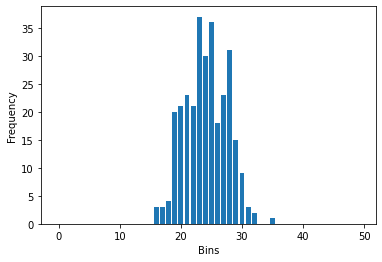

Accuracy: 0.8478
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.423679
Train Epoch: 17 [1280/60000 (2%)]	Loss: 0.430613
Train Epoch: 17 [2560/60000 (4%)]	Loss: 0.512049
Train Epoch: 17 [3840/60000 (6%)]	Loss: 0.292207
Train Epoch: 17 [5120/60000 (9%)]	Loss: 0.431013
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.520739
Train Epoch: 17 [7680/60000 (13%)]	Loss: 0.436805
Train Epoch: 17 [8960/60000 (15%)]	Loss: 2.316011
Train Epoch: 17 [10240/60000 (17%)]	Loss: 2.275893
Train Epoch: 17 [11520/60000 (19%)]	Loss: 2.146933
Train Epoch: 17 [12800/60000 (21%)]	Loss: 1.840770
Train Epoch: 17 [14080/60000 (23%)]	Loss: 1.627534
Train Epoch: 17 [15360/60000 (26%)]	Loss: 1.328344
Train Epoch: 17 [16640/60000 (28%)]	Loss: 1.174137
Train Epoch: 17 [17920/60000 (30%)]	Loss: 0.913463
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.880731
Train Epoch: 17 [20480/60000 (34%)]	Loss: 0.846636
Train Epoch: 17 [21760/60000 (36%)]	Loss: 1.184617
Train Epoch: 17 [23040/60000 (38%)]	Loss: 0.555113
Train Epoch: 17 [24320/60000 (

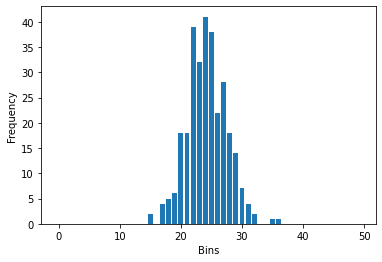

Accuracy: 0.8551
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.431718
Train Epoch: 18 [1280/60000 (2%)]	Loss: 0.385449
Train Epoch: 18 [2560/60000 (4%)]	Loss: 0.524084
Train Epoch: 18 [3840/60000 (6%)]	Loss: 0.726063
Train Epoch: 18 [5120/60000 (9%)]	Loss: 0.597301
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.746597
Train Epoch: 18 [7680/60000 (13%)]	Loss: 0.652670
Train Epoch: 18 [8960/60000 (15%)]	Loss: 0.420613
Train Epoch: 18 [10240/60000 (17%)]	Loss: 0.493902
Train Epoch: 18 [11520/60000 (19%)]	Loss: 0.918690
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.525711
Train Epoch: 18 [14080/60000 (23%)]	Loss: 0.485128
Train Epoch: 18 [15360/60000 (26%)]	Loss: 0.818825
Train Epoch: 18 [16640/60000 (28%)]	Loss: 0.408259
Train Epoch: 18 [17920/60000 (30%)]	Loss: 0.473582
Train Epoch: 18 [19200/60000 (32%)]	Loss: 1.835132
Train Epoch: 18 [20480/60000 (34%)]	Loss: 0.648106
Train Epoch: 18 [21760/60000 (36%)]	Loss: 0.305665
Train Epoch: 18 [23040/60000 (38%)]	Loss: 0.427319
Train Epoch: 18 [24320/60000 (

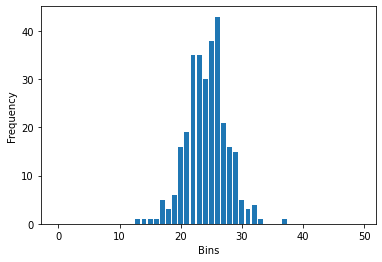

Accuracy: 0.6801
Train Epoch: 19 [0/60000 (0%)]	Loss: 1.252265
Train Epoch: 19 [1280/60000 (2%)]	Loss: 0.516416
Train Epoch: 19 [2560/60000 (4%)]	Loss: 0.573922
Train Epoch: 19 [3840/60000 (6%)]	Loss: 0.655854
Train Epoch: 19 [5120/60000 (9%)]	Loss: 0.338335
Train Epoch: 19 [6400/60000 (11%)]	Loss: 1.345418
Train Epoch: 19 [7680/60000 (13%)]	Loss: 0.460021
Train Epoch: 19 [8960/60000 (15%)]	Loss: 0.486592
Train Epoch: 19 [10240/60000 (17%)]	Loss: 0.481312
Train Epoch: 19 [11520/60000 (19%)]	Loss: 0.531695
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.415028
Train Epoch: 19 [14080/60000 (23%)]	Loss: 0.366583
Train Epoch: 19 [15360/60000 (26%)]	Loss: 0.383974
Train Epoch: 19 [16640/60000 (28%)]	Loss: 0.415998
Train Epoch: 19 [17920/60000 (30%)]	Loss: 0.417373
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.833955
Train Epoch: 19 [20480/60000 (34%)]	Loss: 0.908482
Train Epoch: 19 [21760/60000 (36%)]	Loss: 0.381798
Train Epoch: 19 [23040/60000 (38%)]	Loss: 0.284786
Train Epoch: 19 [24320/60000 (

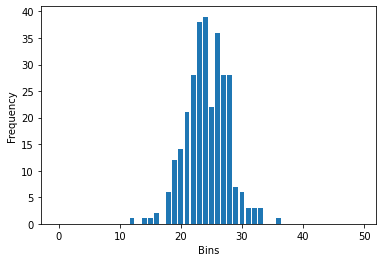

Accuracy: 0.8665
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.368351
Train Epoch: 20 [1280/60000 (2%)]	Loss: 0.383920
Train Epoch: 20 [2560/60000 (4%)]	Loss: 0.460041
Train Epoch: 20 [3840/60000 (6%)]	Loss: 0.414318
Train Epoch: 20 [5120/60000 (9%)]	Loss: 0.402348
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.352582
Train Epoch: 20 [7680/60000 (13%)]	Loss: 0.574645
Train Epoch: 20 [8960/60000 (15%)]	Loss: 0.447104
Train Epoch: 20 [10240/60000 (17%)]	Loss: 0.403586
Train Epoch: 20 [11520/60000 (19%)]	Loss: 0.385773
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.362918
Train Epoch: 20 [14080/60000 (23%)]	Loss: 0.491551
Train Epoch: 20 [15360/60000 (26%)]	Loss: 0.727989
Train Epoch: 20 [16640/60000 (28%)]	Loss: 0.438042
Train Epoch: 20 [17920/60000 (30%)]	Loss: 0.391126
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.455522
Train Epoch: 20 [20480/60000 (34%)]	Loss: 0.467585
Train Epoch: 20 [21760/60000 (36%)]	Loss: 0.297210
Train Epoch: 20 [23040/60000 (38%)]	Loss: 0.399666
Train Epoch: 20 [24320/60000 (

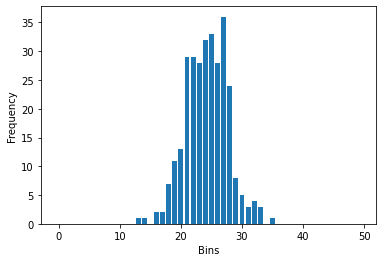

Accuracy: 0.8722
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.476411
Train Epoch: 21 [1280/60000 (2%)]	Loss: 0.339118
Train Epoch: 21 [2560/60000 (4%)]	Loss: 0.493899
Train Epoch: 21 [3840/60000 (6%)]	Loss: 0.695500
Train Epoch: 21 [5120/60000 (9%)]	Loss: 0.634565
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.488858
Train Epoch: 21 [7680/60000 (13%)]	Loss: 0.406662
Train Epoch: 21 [8960/60000 (15%)]	Loss: 0.480968
Train Epoch: 21 [10240/60000 (17%)]	Loss: 0.392786
Train Epoch: 21 [11520/60000 (19%)]	Loss: 0.528147
Train Epoch: 21 [12800/60000 (21%)]	Loss: 0.365104
Train Epoch: 21 [14080/60000 (23%)]	Loss: 0.241698
Train Epoch: 21 [15360/60000 (26%)]	Loss: 1.013215
Train Epoch: 21 [16640/60000 (28%)]	Loss: 0.273745
Train Epoch: 21 [17920/60000 (30%)]	Loss: 0.352246
Train Epoch: 21 [19200/60000 (32%)]	Loss: 0.551126
Train Epoch: 21 [20480/60000 (34%)]	Loss: 0.481799
Train Epoch: 21 [21760/60000 (36%)]	Loss: 0.424250
Train Epoch: 21 [23040/60000 (38%)]	Loss: 0.402952
Train Epoch: 21 [24320/60000 (

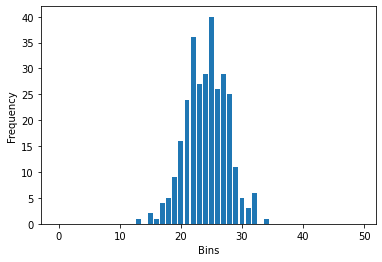

Accuracy: 0.8806
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.294491
Train Epoch: 22 [1280/60000 (2%)]	Loss: 0.409109
Train Epoch: 22 [2560/60000 (4%)]	Loss: 0.485335
Train Epoch: 22 [3840/60000 (6%)]	Loss: 0.526665
Train Epoch: 22 [5120/60000 (9%)]	Loss: 0.574500
Train Epoch: 22 [6400/60000 (11%)]	Loss: 0.361881
Train Epoch: 22 [7680/60000 (13%)]	Loss: 0.293836
Train Epoch: 22 [8960/60000 (15%)]	Loss: 0.333160
Train Epoch: 22 [10240/60000 (17%)]	Loss: 0.409337
Train Epoch: 22 [11520/60000 (19%)]	Loss: 0.433430
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.310422
Train Epoch: 22 [14080/60000 (23%)]	Loss: 0.241307
Train Epoch: 22 [15360/60000 (26%)]	Loss: 0.455412
Train Epoch: 22 [16640/60000 (28%)]	Loss: 0.513614
Train Epoch: 22 [17920/60000 (30%)]	Loss: 0.392130
Train Epoch: 22 [19200/60000 (32%)]	Loss: 0.557033
Train Epoch: 22 [20480/60000 (34%)]	Loss: 0.409010
Train Epoch: 22 [21760/60000 (36%)]	Loss: 0.201366
Train Epoch: 22 [23040/60000 (38%)]	Loss: 0.597159
Train Epoch: 22 [24320/60000 (

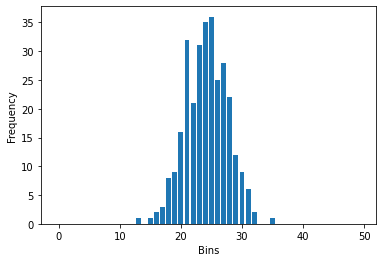

Accuracy: 0.8291
Train Epoch: 23 [0/60000 (0%)]	Loss: 0.614898
Train Epoch: 23 [1280/60000 (2%)]	Loss: 0.563245
Train Epoch: 23 [2560/60000 (4%)]	Loss: 0.467961
Train Epoch: 23 [3840/60000 (6%)]	Loss: 0.733105
Train Epoch: 23 [5120/60000 (9%)]	Loss: 0.746522
Train Epoch: 23 [6400/60000 (11%)]	Loss: 0.381745
Train Epoch: 23 [7680/60000 (13%)]	Loss: 0.374948
Train Epoch: 23 [8960/60000 (15%)]	Loss: 0.390263
Train Epoch: 23 [10240/60000 (17%)]	Loss: 0.511477
Train Epoch: 23 [11520/60000 (19%)]	Loss: 0.434356
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.323763
Train Epoch: 23 [14080/60000 (23%)]	Loss: 0.446885
Train Epoch: 23 [15360/60000 (26%)]	Loss: 0.378402
Train Epoch: 23 [16640/60000 (28%)]	Loss: 0.298110
Train Epoch: 23 [17920/60000 (30%)]	Loss: 0.653227
Train Epoch: 23 [19200/60000 (32%)]	Loss: 0.438460
Train Epoch: 23 [20480/60000 (34%)]	Loss: 0.447470
Train Epoch: 23 [21760/60000 (36%)]	Loss: 0.558610
Train Epoch: 23 [23040/60000 (38%)]	Loss: 0.373221
Train Epoch: 23 [24320/60000 (

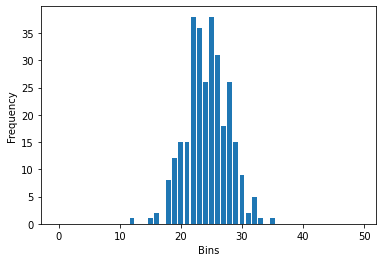

Accuracy: 0.8799
Train Epoch: 24 [0/60000 (0%)]	Loss: 0.410853
Train Epoch: 24 [1280/60000 (2%)]	Loss: 0.330091
Train Epoch: 24 [2560/60000 (4%)]	Loss: 0.355873
Train Epoch: 24 [3840/60000 (6%)]	Loss: 0.307734
Train Epoch: 24 [5120/60000 (9%)]	Loss: 0.670393
Train Epoch: 24 [6400/60000 (11%)]	Loss: 0.310481
Train Epoch: 24 [7680/60000 (13%)]	Loss: 0.444065
Train Epoch: 24 [8960/60000 (15%)]	Loss: 2.295057
Train Epoch: 24 [10240/60000 (17%)]	Loss: 2.095755
Train Epoch: 24 [11520/60000 (19%)]	Loss: 2.384345
Train Epoch: 24 [12800/60000 (21%)]	Loss: 2.309314
Train Epoch: 24 [14080/60000 (23%)]	Loss: 2.275369
Train Epoch: 24 [15360/60000 (26%)]	Loss: 2.307071
Train Epoch: 24 [16640/60000 (28%)]	Loss: 2.320784
Train Epoch: 24 [17920/60000 (30%)]	Loss: 2.285681
Train Epoch: 24 [19200/60000 (32%)]	Loss: 2.295224
Train Epoch: 24 [20480/60000 (34%)]	Loss: 2.292006
Train Epoch: 24 [21760/60000 (36%)]	Loss: 2.282540
Train Epoch: 24 [23040/60000 (38%)]	Loss: 2.300539
Train Epoch: 24 [24320/60000 (

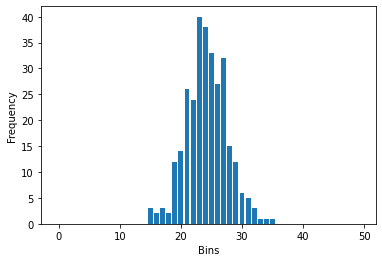

Accuracy: 0.1135
Train Epoch: 25 [0/60000 (0%)]	Loss: 2.318420


KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt
#torch.autograd.set_detect_anomaly(True)
# train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_intrinsic.parameters(), lr=0.1)

# training step
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


# testing step
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[
                1
            ]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    # show an histogram of the weights of the model
    for param in model.parameters():
        if param.requires_grad:
            hist = torch.histc(param.data, bins = 50, min = -2, max = 2)
            bins = 30
            x = range(bins)
            plt.bar(x, hist, align='center')
            plt.xlabel('Bins')
            plt.ylabel('Frequency')
            plt.show()

    return correct / len(test_loader.dataset)


# train the model
for epoch in range(1, 100):
    train(model_intrinsic, train_dataloader, optimizer, criterion, epoch)
    accuracy = test(model_intrinsic, test_dataloader, criterion)
    print("Accuracy: {}".format(accuracy))
